In [67]:
import os
os.listdir()


['.config',
 'ball.jpeg',
 'edge.jpeg',
 'flat.jpeg',
 'corner.jpeg',
 'top.jpeg',
 '.ipynb_checkpoints',
 'sample_data']

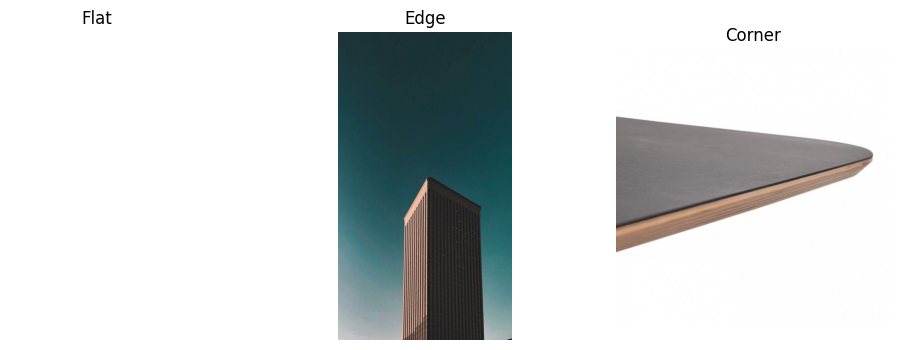

In [51]:
flat   = cv2.imread("flat.jpeg")
edge   = cv2.imread("edge.jpeg")
corner = cv2.imread("corner.jpeg")


flat   = cv2.cvtColor(flat, cv2.COLOR_BGR2RGB)
edge   = cv2.cvtColor(edge, cv2.COLOR_BGR2RGB)
corner = cv2.cvtColor(corner, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(flat);   plt.title("Flat");   plt.axis("off")
plt.subplot(1,3,2); plt.imshow(edge);   plt.title("Edge");   plt.axis("off")
plt.subplot(1,3,3); plt.imshow(corner); plt.title("Corner"); plt.axis("off")
plt.show()


In [52]:
SOBEL_X = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float32)

SOBEL_Y = np.array([[-1,-2,-1],
                    [ 0, 0, 0],
                    [ 1, 2, 1]], dtype=np.float32)


In [53]:
def convolve2d(image, kernel):
    h, w = image.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh//2, kw//2

    padded = np.pad(image, ((pad_h,pad_h),(pad_w,pad_w)), mode='constant')
    out = np.zeros_like(image, dtype=np.float32)

    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            out[i,j] = np.sum(region * kernel)

    return out


In [54]:
def sobel_analysis(img, threshold=None):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.float32) / 255.0

    Ix = convolve2d(gray, SOBEL_X)
    Iy = convolve2d(gray, SOBEL_Y)

    ix, iy = Ix.flatten(), Iy.flatten()

    if threshold is not None:
        mask = (np.abs(ix) > threshold) | (np.abs(iy) > threshold)
        ix, iy = ix[mask], iy[mask]

    plt.scatter(ix, iy, s=1)
    plt.xlabel("Ix")
    plt.ylabel("Iy")
    plt.title("Iy vs Ix Scatter Plot")
    plt.grid(True)
    plt.show()

    return Ix, Iy


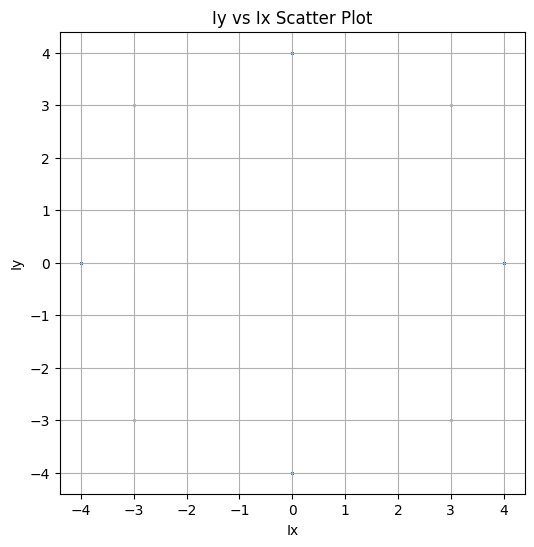

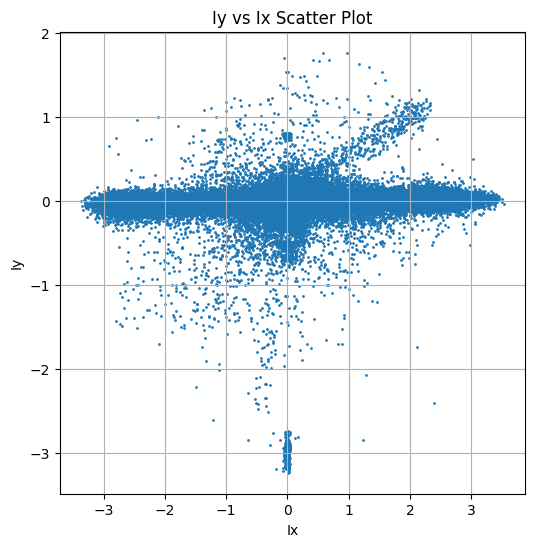

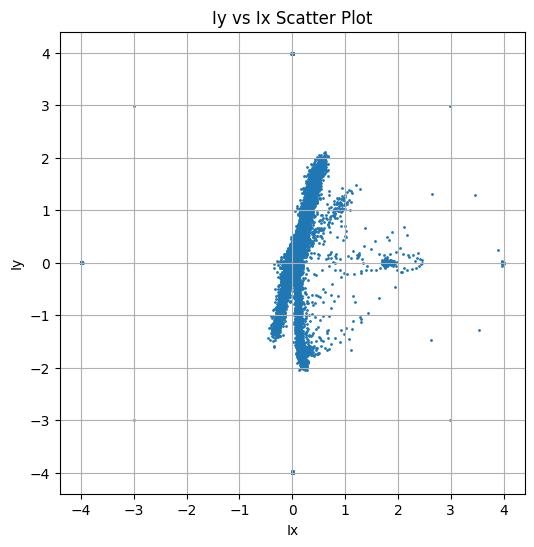

In [55]:
Ix_f, Iy_f = sobel_analysis(flat, threshold=0.02)
Ix_e, Iy_e = sobel_analysis(edge, threshold=0.02)
Ix_c, Iy_c = sobel_analysis(corner, threshold=0.02)


In [56]:
def harris_r_map(Ix, Iy, window=5, k=0.04):
    h, w = Ix.shape
    offset = window // 2
    R = np.zeros((h,w), dtype=np.float32)

    for i in range(offset, h-offset):
        for j in range(offset, w-offset):
            ix = Ix[i-offset:i+offset+1, j-offset:j+offset+1]
            iy = Iy[i-offset:i+offset+1, j-offset:j+offset+1]

            a = np.sum(ix*ix)
            b = np.sum(ix*iy)
            c = np.sum(iy*iy)

            det = a*c - b*b
            trace = a + c
            R[i,j] = det - k*(trace**2)

    return R


In [57]:
def show_r_map(R):
    plt.imshow(R, cmap='hot')
    plt.colorbar()
    plt.title("Harris R Map")
    plt.axis("off")
    plt.show()


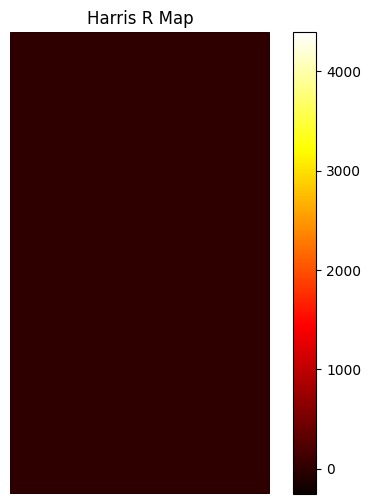

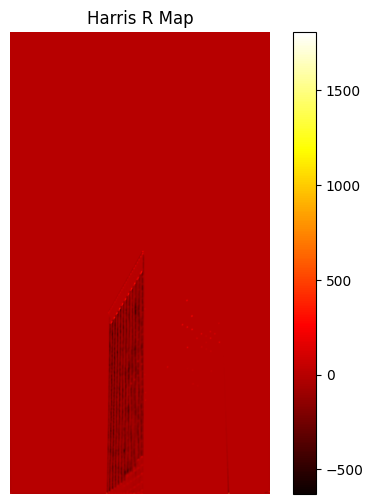

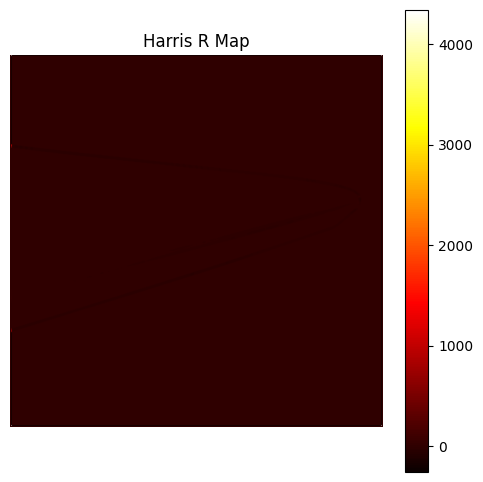

In [58]:
R_flat   = harris_r_map(Ix_f, Iy_f)
R_edge   = harris_r_map(Ix_e, Iy_e)
R_corner = harris_r_map(Ix_c, Iy_c)

show_r_map(R_flat)
show_r_map(R_edge)
show_r_map(R_corner)


In [59]:
def canny_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.Canny(gray, 100, 200)


In [60]:
top = cv2.imread("top.jpeg")
top = cv2.cvtColor(top, cv2.COLOR_BGR2RGB)
top = cv2.resize(top, (300,300))

edges = canny_edges(top)


In [61]:
def hough_slope_intercept(edges, m_bins=180, b_bins=180):
    h, w = edges.shape
    m_vals = np.linspace(-2, 2, m_bins)
    b_vals = np.linspace(-h, h, b_bins)
    acc = np.zeros((m_bins, b_bins))

    ys, xs = np.nonzero(edges)

    for x, y in zip(xs, ys):
        for mi, m in enumerate(m_vals):
            b = y - m*x
            if -h <= b <= h:
                bi = int((b + h)/(2*h)*(b_bins-1))
                acc[mi,bi] += 1

    return acc, m_vals, b_vals


In [62]:
def hough_rho_theta(edges):
    h, w = edges.shape
    diag = int(np.sqrt(h*h + w*w))
    rhos = np.linspace(-diag, diag, 2*diag)
    thetas = np.linspace(-np.pi/2, np.pi/2, 180)
    acc = np.zeros((len(rhos), len(thetas)))

    ys, xs = np.nonzero(edges)

    for x,y in zip(xs,ys):
        for ti,theta in enumerate(thetas):
            rho = x*np.cos(theta) + y*np.sin(theta)
            ri = np.argmin(np.abs(rhos-rho))
            acc[ri,ti] += 1

    return acc, rhos, thetas


(np.float64(-0.5), np.float64(735.5), np.float64(1103.5), np.float64(-0.5))

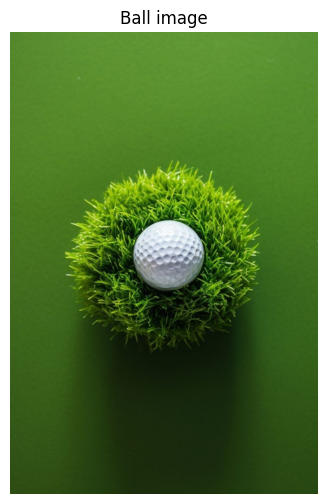

In [63]:
ball = cv2.imread("ball.jpeg")
ball = cv2.cvtColor(ball, cv2.COLOR_BGR2RGB)

plt.imshow(ball)
plt.title("Ball image")
plt.axis("off")


In [64]:
def extract_ball(image, x1,y1,x2,y2):
    crop = image[y1:y2, x1:x2]
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    b,g,r = cv2.split(crop)
    rgba = cv2.merge([b,g,r,mask])
    return rgba


In [65]:
def overlay_ball(bg, stencil, cx, cy):
    h, w, _ = stencil.shape
    y1, y2 = int(cy - h//2), int(cy + h//2)
    x1, x2 = int(cx - w//2), int(cx + w//2)

    alpha = stencil[:,:,3] / 255.0

    for c in range(3):
        bg[y1:y2, x1:x2, c] = (
            alpha * stencil[:,:,c] +
            (1 - alpha) * bg[y1:y2, x1:x2, c]
        )
    return bg


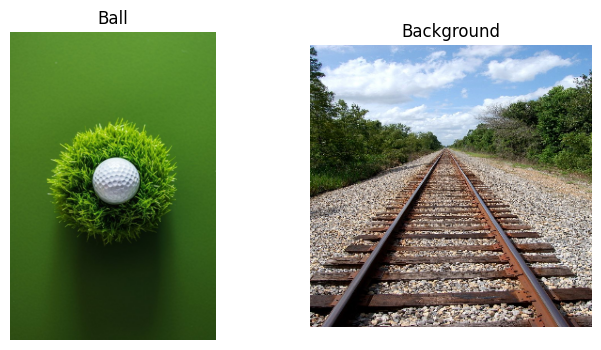

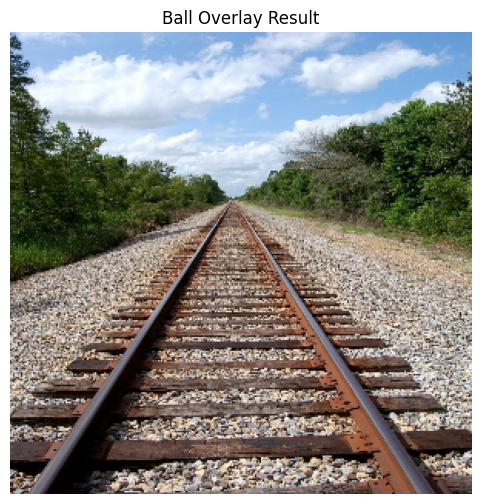

In [66]:

top = cv2.imread("top.jpeg")
top = cv2.cvtColor(top, cv2.COLOR_BGR2RGB)
top = cv2.resize(top, (300, 300))


ball = cv2.imread("ball.jpeg")
ball = cv2.cvtColor(ball, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(ball); plt.title("Ball"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(top);  plt.title("Background"); plt.axis("off")
plt.show()


stencil = extract_ball(ball, 50, 50, 200, 200)

h_bg, w_bg, _ = top.shape
h_s, w_s, _ = stencil.shape

cx = w_bg // 2
cy = h_bg // 2

cx = min(max(cx, w_s//2), w_bg - w_s//2)
cy = min(max(cy, h_s//2), h_bg - h_s//2)


result = overlay_ball(top.copy(), stencil, cx, cy)

plt.imshow(result)
plt.title("Ball Overlay Result")
plt.axis("off")
plt.show()
